# Using the Multi threaded cluster finder 

- Slightly more complicated than the single threader version
- Pay attention to start and stop
- Can become the default?

In [1]:
#add the aare build folder to sys.path to make it visible to python
import sys
sys.path.append('/home/l_msdetect/erik/aare/build')

#Our normal python imports
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import boost_histogram as bh
import time

#Directly import what we need from aare
from aare import File, ClusterFile, hitmap
from aare._aare import calculate_eta2, ClusterFinderMT, ClusterCollector

base = Path('/mnt/sls_det_storage/matterhorn_data/aare_test_data/')

## Pedestal

- Calculate the pedestal
- cf.sync() makes sure the pedestal is processsed
- Slower than the single threaded case since we need to do the same work n_threads times

In [2]:
#In this example we set up the pedestal using the beginning of the file
#Better would of course be a dedicated dark measurement
f = File(base/'Moench03new/cu_half_speed_master_4.json')

n_frames_pd = 1000
cluster_size = (3,3)
image_size = (f.rows, f.cols)

#Read n_frames_pd from f and use them to calculate the 
#initial pedestal
t0 = time.perf_counter()
cf = ClusterFinderMT(image_size, cluster_size, capacity = 2000, n_threads=32)

#Connect a sink to the ClusterFinder, this will pull all clustered frames
#and add it to a vector of ClusterVectors
sink = ClusterCollector(cf)

#Actually push the pedestal images
for i in range(n_frames_pd):
    cf.push_pedestal_frame(f.read_frame())
elapsed_t = time.perf_counter()-t0

cf.sync() #Wait until the input queue is empty
print(f'Pedestal took: {elapsed_t:.3f}s')

Pedestal took: 1.700s


## Run cluster finding

In [3]:
t_start = time.perf_counter()
N = 40000
t0 = time.perf_counter()
hist1 = bh.Histogram(bh.axis.Regular(40, -2, 4000))

#Not needed, just here for reproducibility when executing the cell over and over
f.seek(n_frames_pd) 

#Read N frames from the file. Better would be to read frame by frame but we want them in memory
#to isolate the cluster finding benchmark
t0 = time.perf_counter()
data = f.read_n(N)
t_elapsed = time.perf_counter()-t0
print(f'Reading {N} frames took {t_elapsed:.3f}s {N/t_elapsed:.0f} FPS, {f.bytes_per_frame*N/1024**2:.3f} GB/s')

#Run clustering on all frames in data
t0 = time.perf_counter()
for frame in data:
    cf.find_clusters(frame)
t_elapsed = time.perf_counter()-t0

cf.stop()
sink.stop()
print(f'Clustering {N} frames took {t_elapsed:.2f}s  {N/t_elapsed:.0f} FPS')


#Fill a boost-histogram with the sum of each cluster
t0 = time.perf_counter()
clusters = sink.steal_clusters()
total_clusters = 0
for cv in clusters:
    hist1.fill(cv.sum())
    total_clusters += cv.size

t_elapsed = time.perf_counter()-t0
print(f'Filling histogram with the sum of {total_clusters} clusters took: {t_elapsed:.3f}s, {total_clusters/t_elapsed:.3g} clust/s')
print(f'Average number of clusters per frame {total_clusters/N:.3f}')

print(f'Cell time: {time.perf_counter()-t_start:.3f}s')

Reading 40000 frames took 1.985s 20154 FPS, 12207.031 GB/s
Clustering 40000 frames took 5.56s  7195 FPS
Filling histogram with the sum of 53041644 clusters took: 0.763s, 6.95e+07 clust/s
Average number of clusters per frame 1326.041
Cell time: 9.214s


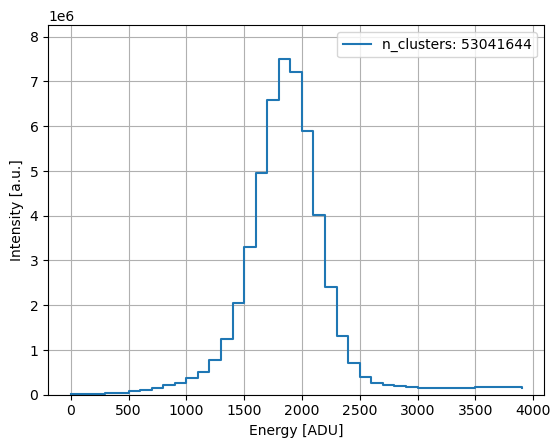

In [4]:
#plot the histogram
fig, ax = plt.subplots()
ax.step(hist1.axes[0].edges[:-1], hist1.values(), where="post", label = f'n_clusters: {total_clusters}');
ax.set_xlabel('Energy [ADU]')
ax.set_ylabel('Intensity [a.u.]')
ax.legend()
ax.set_ylim(0, hist1.values().max()*1.1)
ax.grid()

Filling hitmap took: 3.960s


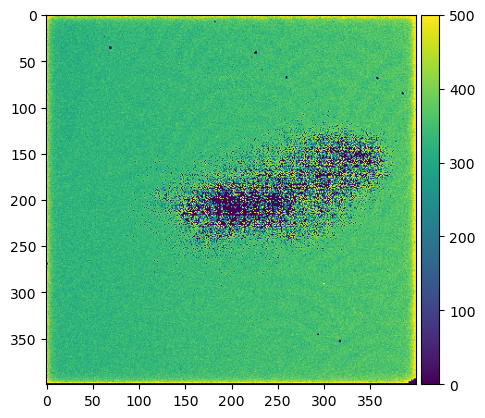

In [5]:
t0 = time.perf_counter()
img = np.zeros((400,400))
for cv in clusters:
    img += hitmap((400,400),cv)
elapsed_t = time.perf_counter()-t0
print(f'Filling hitmap took: {elapsed_t:.3f}s')

fig, ax = plt.subplots()
im = ax.imshow(img)
im.set_clim(0,500)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)